<a href="https://colab.research.google.com/github/Tantatorn-dev/boku-no-notebooks/blob/master/monkey_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# retrieve the data

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

[Errno 2] No such file or directory: '/content/My Drive/Kaggle'
/content


In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species

 98% 536M/547M [00:21<00:00, 34.5MB/s]
100% 547M/547M [00:21<00:00, 26.8MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
%cd drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
# show basic info
!cat monkey_labels.txt

Label,  Latin Name           , Common Name                   , Train Images , Validation Images
n0   , alouatta_palliata	 , mantled_howler                , 131          , 26
n1   , erythrocebus_patas	 , patas_monkey                  , 139          , 28
n2   , cacajao_calvus	     , bald_uakari                   , 137          , 27
n3   , macaca_fuscata	     , japanese_macaque              , 152          , 30
n4   , cebuella_pygmea	     , pygmy_marmoset                , 131          , 26
n5   , cebus_capucinus	     , white_headed_capuchin         , 141          , 28
n6   , mico_argentatus	     , silvery_marmoset              , 132          , 26
n7   , saimiri_sciureus	     , common_squirrel_monkey        , 142          , 28
n8   , aotus_nigriceps	     , black_headed_night_monkey     , 133          , 27
n9   , trachypithecus_johnii , nilgiri_langur                , 132          , 26














In [2]:
# import necessary libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os

Using TensorFlow backend.


In [3]:
monkey_species = os.listdir('/content/drive/My Drive/Kaggle/training/training')
print("Number of Categories:", len(monkey_species))
print("Categories: ", monkey_species)

Number of Categories: 10
Categories:  ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [4]:
# constant 
width, height = 224,224

train_path = '/content/drive/My Drive/Kaggle/training/training'
validation_path = '/content/drive/My Drive/Kaggle/validation/validation'
batch_size = 4

In [5]:
# data preparation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


(4, 224, 224, 3)
(4, 10)


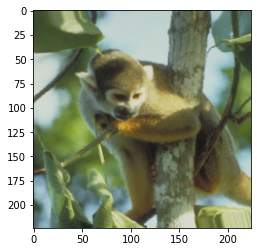

In [6]:
# let's see some training image
x,y = train_generator.next()
print(x.shape)
print(y.shape)
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [8]:
# create a model based on ResNet50 
resnet = ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

# fine tuning
model = resnet.output
model = layers.GlobalAveragePooling2D()(model)
model = layers.Dense(512,activation='relu')(model)
model = layers.Dense(10, activation='softmax')(model)

model = models.Model(inputs=resnet.input, outputs=model)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________

In [9]:
# compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11901059247576013136
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1951723445400690944
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17239893130387251064
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14192278735592025164
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [12]:
# train a model
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history = model.fit_generator(
    train_generator,
    epochs=50, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/50
275/275 [==============================] - 64s 234ms/step - loss: 1.4595 - accuracy: 0.4435 - val_loss: 4.2888 - val_accuracy: 0.3750
Epoch 2/50
275/275 [==============================] - 63s 230ms/step - loss: 1.3892 - accuracy: 0.4599 - val_loss: 1.0571 - val_accuracy: 0.5515
Epoch 3/50
275/275 [==============================] - 63s 228ms/step - loss: 1.3415 - accuracy: 0.5091 - val_loss: 1.6619 - val_accuracy: 0.4301
Epoch 4/50
275/275 [==============================] - 63s 229ms/step - loss: 1.2799 - accuracy: 0.5209 - val_loss: 0.8163 - val_accuracy: 0.5221
Epoch 5/50
275/275 [==============================] - 63s 228ms/step - loss: 1.1849 - accuracy: 0.5528 - val_loss: 2.4648 - val_accuracy: 0.3971
Epoch 6/50
275/275 [==============================] - 63s 229ms/step - loss: 1.1159 - accuracy: 0.5893 - val_loss: 1.1489 - val_accuracy: 0.5478
Epoch 7/50
275/275 [==============================] - 63s 230ms/step - loss: 1.0829 - accuracy: 0.5902 - val_loss: 0.3303 - val_ac